##Tasks Done:
####Gokul Krishna


1.   Own solution for  Preprocessing
2.   Data cleaning, reading with correct format
3.   Visualising
4.   BiLstm modelling, evaluation, Fine-Tuning of two rounds




In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/dataset/Sentiment_Data/Sentiment_Data.csv'

In [ ]:
import os

if os.path.exists(file_path):
  print("file exists")
else:
  print("file does not exists")

file exists


In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv(file_path)
df.head(5)

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 211300-211301: invalid continuation byte

##It says file can't be decoded with the utf-8 codec Let us check the Unicode Format of the file

In [ ]:
import chardet

file_path = '/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data.csv'

# Read a sample of the file in binary mode
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(100000))  # Reads first 100 KB of the file

# Print detected encoding
print("Detected encoding:", result['encoding'])


Detected encoding: MacRoman


### Now I am converting the file to the UTF-8 (padas' default encoding format) for better compatability

In [ ]:
# Step 1: Read the original file as raw bytes using MacRoman encoding
with open('/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data.csv', 'rb') as f:
    raw_data = f.read()

# Step 2: Decode the bytes using utf8 encoding
decoded_data = raw_data.decode('utf-8', errors='ignore')

# Step 3: Save the decoded content as a new UTF-8 encoded file
utf8_path = '/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv'
with open(utf8_path, 'w', encoding='utf-8') as f:
    f.write(decoded_data)

# Step 4: Load the UTF-8 file into a DataFrame
df = pd.read_csv(utf8_path, encoding='utf-8')

print("File saved in UTF-8 format at:", utf8_path)


File saved in UTF-8 format at: /content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv


##Reading the saved UTF-8 File

In [ ]:
df_UTF = pd.read_csv(utf8_path)
df.head(5)

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [ ]:
number_of_words=len(df.Tweet.unique())
print("Number of unique words in the tweet: ", number_of_words)

Number of unique words in the tweet:  451280


In [ ]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  11774376 


the: 513232
freedom: 384551
convoy: 372405
t: 298687
to: 257765
co: 243036
https: 241352
of: 186826
and: 167120
a: 156799
in: 138468
is: 119851
for: 104722
s: 98675
freedomconvoy: 94086
you: 91554
it: 82275
i: 82205
that: 81592
on: 70945


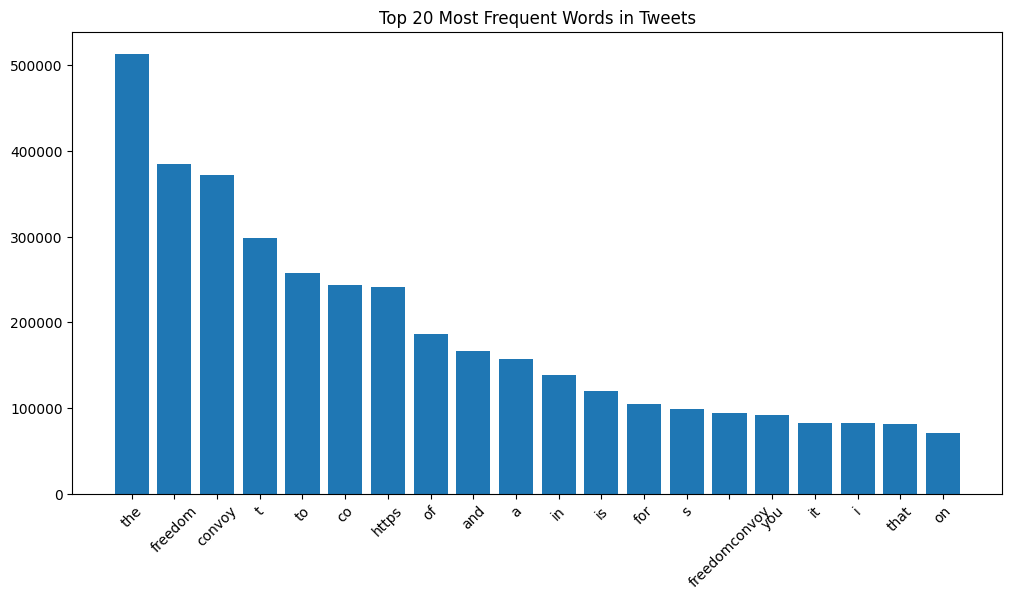

In [ ]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


## we can count check and count for the labels and check for the imbalance

In [ ]:
df.Sentiment.unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64


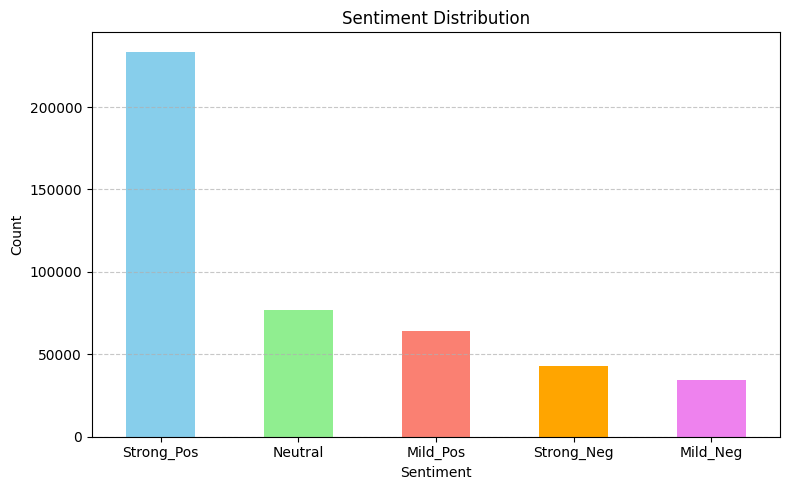

In [ ]:
import matplotlib.pyplot as plt

# Get counts of unique sentiment labels
sentiment_counts = df['Sentiment'].value_counts()

# Display the counts
print(sentiment_counts)

# Plotting
plt.figure(figsize=(8, 5))
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'violet']  # extend as needed

# Bar plot
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


 Huge imbalance exists for the positive words

## preprocessing the the Sentiment column

###Function for preprocessing:

1.Converts text to lowercase

2.Removes URLs

3.Removes Twitter mentions (@user)

4.Removes hashtag symbols (#) but keeps the word

5.Removes punctuation

6.Removes numbers

7.Splits text into individual words (tokenization)

8.Removes stopwords (like "the", "is", "and")

9.Removes very short words (length ≤ 1)

10.Lemmatizes each word to its base form (e.g., "running" → "run")

11.Joins the cleaned words back into a single string

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')  # also needed for lemmatization
nltk.download('omw-1.4')  # optional but helps lemmatizer with more words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function with comments
def preprocess_text_with_lemmatization(text):
    # 1. Convert any input to string to avoid errors with floats/NaNs
    text = str(text)

    # 2. Convert text to lowercase
    text = text.lower()

    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # 4. Remove mentions, hashtags, and special characters
    text = re.sub(r"@\w+|#\w+|[^a-z\s]", "", text)

    # 5. Tokenize the text
    words = text.split()

    # 6. Remove stopwords
    words = [word for word in words if word not in stop_words]

    # 7. Lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words]

    # 8. Join words back into a single string
    return " ".join(words)


In [ ]:
# Apply the preprocessing function to each row in the 'Tweet' column
df['cleaned_Tweet'] = df['Tweet'].apply(preprocess_text_with_lemmatization)

# Display the first few cleaned tweets
df[['Tweet', 'cleaned_Tweet']].head()


,Tweet,cleaned_Tweet
0,@_angelica_toy Happy Anniversary!!!....The Day...,happy anniversarythe day freedumb died tune mc...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,happy anniversarythe day freedumb died tune mc...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,happy anniversarythe day freedumb died tune mc...
3,@NChartierET Happy Anniversary!!!....The Day t...,happy anniversarythe day freedumb died tune mc...
4,@tabithapeters05 Happy Anniversary!!!....The D...,happy anniversarythe day freedumb died tune mc...


120 million words cleaned in 38 seconds in colab

###Saving the cleaned file

In [ ]:
cleaned_data = df[['cleaned_Tweet','Sentiment']]
cleaned_data.to_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data.csv', index=False)

In [ ]:
#Checking the existence

if os.path.exists('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data.csv'):
  print("Exists")
else:
  print('Does\'nt exists')

Exists


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data.csv')
df.head()

,cleaned_Tweet,Sentiment
0,happy anniversarythe day freedumb died tune mc...,Mild_Pos
1,happy anniversarythe day freedumb died tune mc...,Mild_Pos
2,happy anniversarythe day freedumb died tune mc...,Mild_Pos
3,happy anniversarythe day freedumb died tune mc...,Mild_Pos
4,happy anniversarythe day freedumb died tune mc...,Mild_Pos


### Now Let's check the word count

In [ ]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['cleaned_Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  5831725 


freedom: 378195
convoy: 367495
ottawa: 57333
trucker: 54975
canada: 51015
canadian: 50282
protest: 44293
via: 43824
people: 41373
trudeau: 31284
police: 29911
amp: 28013
like: 24576
support: 23032
right: 22530
u: 21118
government: 19102
one: 18740
mandate: 17967
dont: 17287


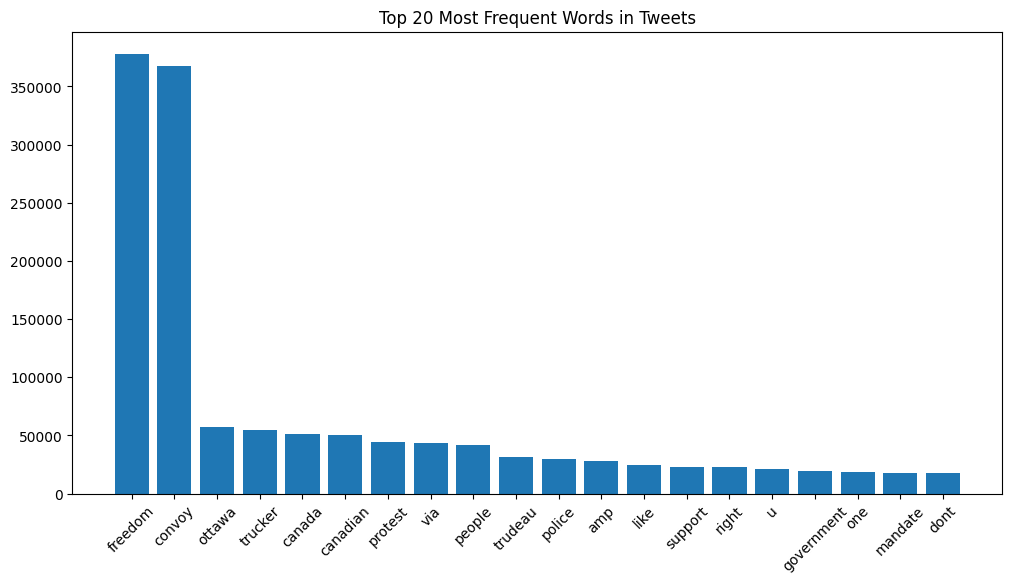

In [ ]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


After cleaning Freedom and convoy are the most occuring one.

## On Second thought....

I think the emojies, punctuation marks, numbers, hashtags should'nt have been removed. So changing the preprocessing little bit....

In [ ]:
!pip install emoji --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 34.3 MB/s eta 0:00:00


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor', 'never'}  # preserve negation
lemmatizer = WordNetLemmatizer()

def preprocess_text_with_lemmatization(text):
    # 1. Convert any input to string
    text = str(text)

    # 2. Convert emojis to text (😊 → smiling_face)
    text = demojize(text, delimiters=(" ", " "))

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # 5. Remove HTML tags and entities
    text = re.sub(r"<.*?>|&\w+;", "", text)

    # 6. Remove unwanted special characters but keep @, #, and numbers
    text = re.sub(r"[^a-z0-9@#:\s!?']", "", text)

    # 7. Tokenize text
    words = text.split()

    # 8. Remove stopwords but preserve negations
    words = [word for word in words if word not in stop_words]

    # 9. Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    # 10. Join cleaned words
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
sample = "Seriously it the best party I've ever seen!.🤩❤️🤠 #FreedomConvoy #FreedomConvoyAnniversary"
print(preprocess_text_with_lemmatization(sample))

seriously best party ever seen! starstruck redheart cowboyhatface #freedomconvoy #freedomconvoyanniversary


In [ ]:
df['cleaned_Tweet'] = df_UTF['Tweet'].astype(str).apply(preprocess_text_with_lemmatization)

df[['cleaned_Tweet', 'Sentiment']].to_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_3.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_3.csv')

#2 minutes

In [ ]:
import pandas as pd
print("Texts before demojizing")
pd.read_csv('/content/drive/My Drive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv').Tweet.iloc[70]


Texts before demojizing


"Seriously it the best party I've ever seen!.🤩❤️🤠\n\n#FreedomConvoy #FreedomConvoyAnniversary"

In [ ]:
print("Texts after demojizing")
df.cleaned_Tweet.iloc[70]

Texts after demojizing


'seriously best party ever seen! starstruck redheart cowboyhatface #freedomconvoy #freedomconvoyanniversary'

In [ ]:
df_cleaned_1 = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data.csv')
comparison_df = pd.DataFrame({
    'Original_cleaned_Tweet': df['cleaned_Tweet'],
    'New_cleaned_Tweet': df_cleaned_1['cleaned_Tweet']
})

# Display the first few rows side by side
comparison_df.head()

,Original_cleaned_Tweet,New_cleaned_Tweet
0,@angelicatoy happy anniversary!!!the day freed...,happy anniversarythe day freedumb died tune mc...
1,@mcfarlaneglenda happy anniversary!!!the day f...,happy anniversarythe day freedumb died tune mc...
2,@thevivafrei @justintrudeau happy anniversary!...,happy anniversarythe day freedumb died tune mc...
3,@nchartieret happy anniversary!!!the day freed...,happy anniversarythe day freedumb died tune mc...
4,@tabithapeters05 happy anniversary!!!the day f...,happy anniversarythe day freedumb died tune mc...


### Checking the word count again!

In [ ]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['cleaned_Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  6911895 


freedom: 385553
convoy: 370463
freedomconvoy: 94541
canada: 83360
ottawa: 65325
trucker: 52521
canadian: 50421
not: 50405
protest: 43910
via: 43825
people: 41349
s: 41267
trudeau: 37771
2022: 31900
police: 30335
youtube: 27835
like: 24569
no: 24174
support: 23065
right: 22163


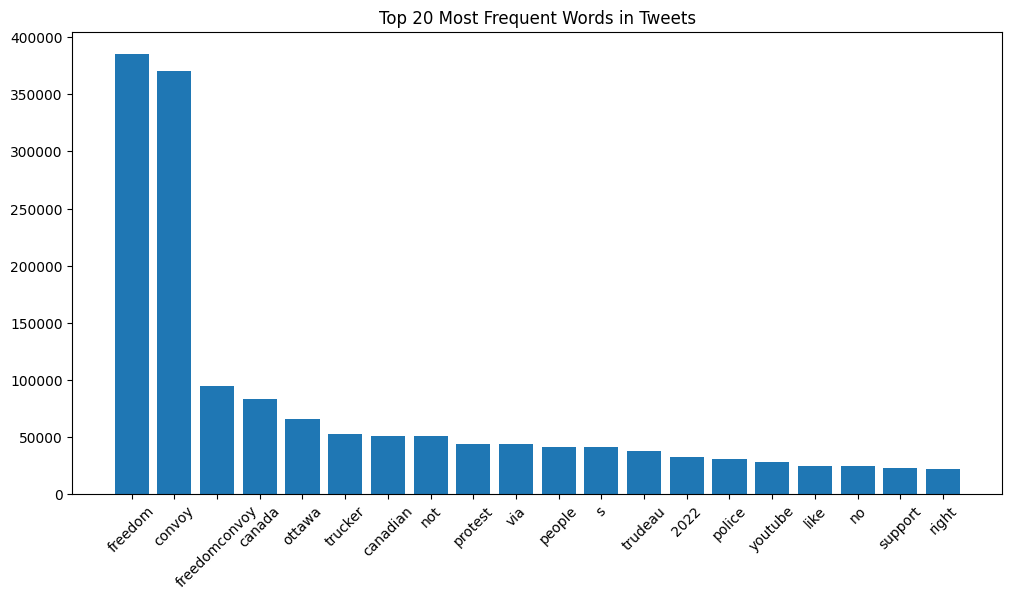

In [ ]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


## Now I just wanted to see the words' frequency distribution across all classes

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_word_freq_for_class(df, sentiment_class, title):
    # Filter and clean text data for the given sentiment class
    text_data = " ".join(df[df['Sentiment'] == sentiment_class]['cleaned_Tweet'].dropna().astype(str))

    # Count word frequencies
    word_counts = Counter(text_data.split())

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Print frequency distribution
    print(f"Top 20 words for class '{sentiment_class}':")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

    # Plotting
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Top 20 words for class 'Mild_Pos':
freedom: 48462
convoy: 46141
#freedomconvoy: 11368
protest: 9293
ottawa: 8994
canada: 7544
trucker: 7419
canadian: 7356
not: 7052
via: 6605
police: 5437
trudeau: 5360
people: 5145
'freedom: 4098
no: 4094
convoy': 3821
like: 3308
emergency: 3297
u: 3114
@youtube: 3067



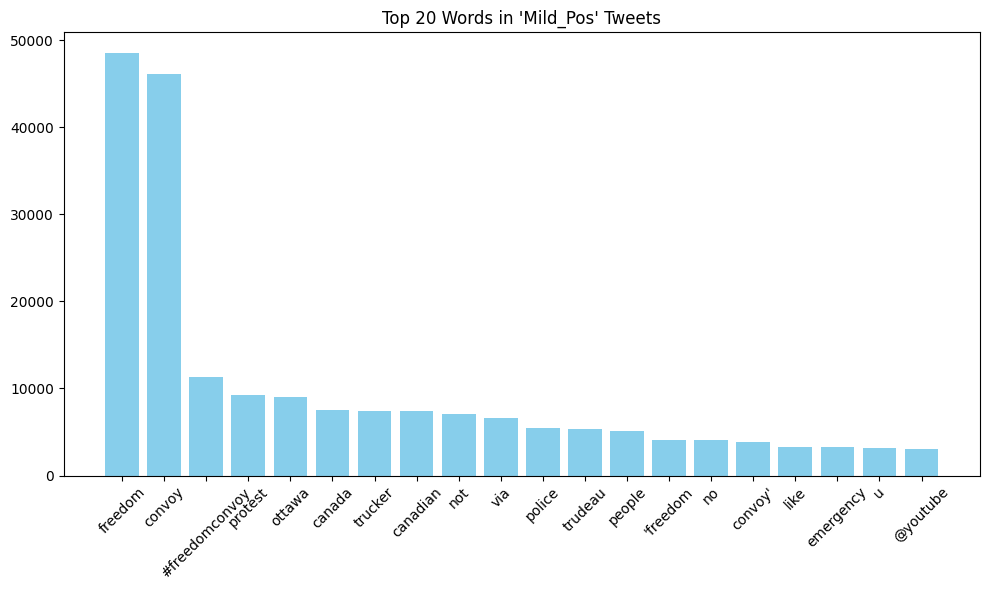

Top 20 words for class 'Strong_Pos':
freedom: 222456
convoy: 198916
canada: 37267
trucker: 29542
ottawa: 29017
via: 28177
canadian: 27479
2022: 24734
not: 23139
people: 19061
@youtube: 18657
#freedomconvoy: 17185
support: 16215
like: 15456
protest: 14725
trudeau: 14085
'freedom: 12476
police: 12159
convoy': 11481
u: 10576



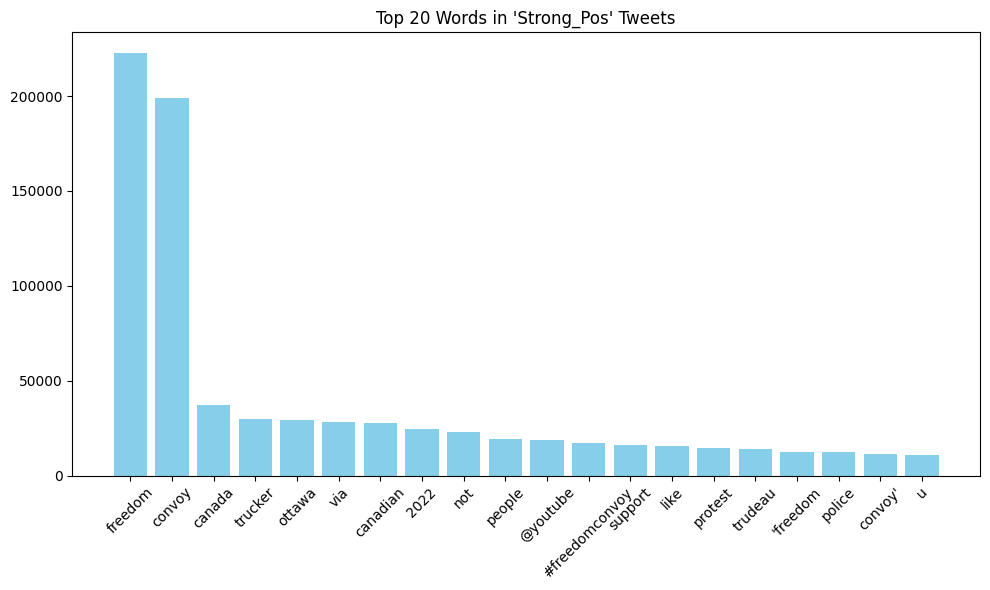

Top 20 words for class 'Neutral':
#freedomconvoy: 35851
convoy: 35663
freedom: 35075
canada: 10267
ottawa: 7083
not: 6306
trucker: 6137
canadian: 5821
protest: 5590
via: 4916
people: 4817
police: 4444
trudeau: 4395
#freedomconvoy2022: 4353
#canada: 3607
de: 3217
no: 3006
#cdnpoli: 2931
right: 2897
#freedom: 2830



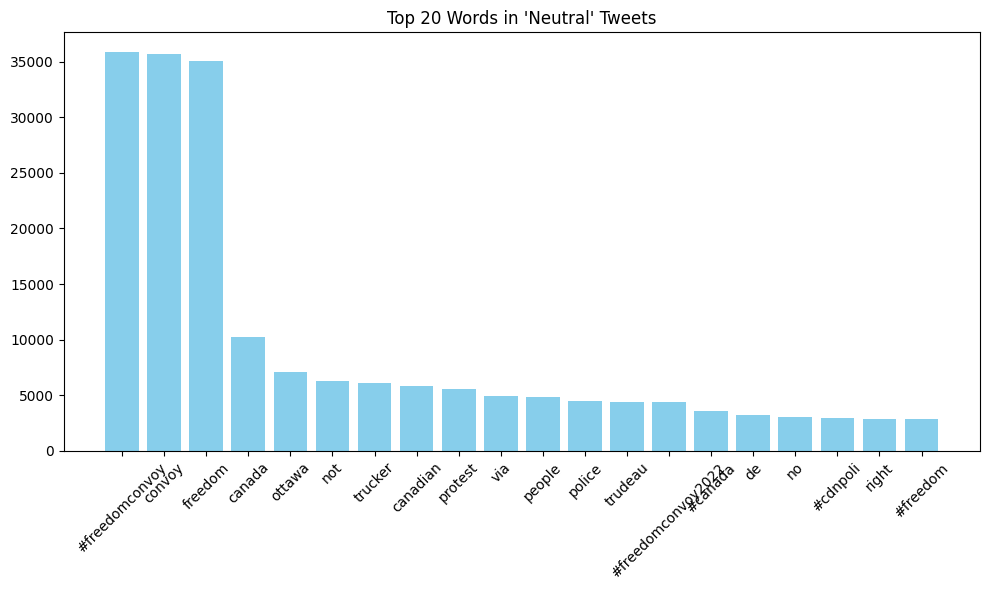

Top 20 words for class 'Strong_Neg':
freedom: 25687
convoy: 25377
#freedomconvoy: 14708
not: 8646
protest: 6226
people: 6009
no: 5867
canada: 5356
ottawa: 4771
canadian: 4635
trucker: 4343
police: 3864
trudeau: 3812
right: 2857
protester: 2712
u: 2478
one: 2460
government: 2361
get: 2207
hate: 2086



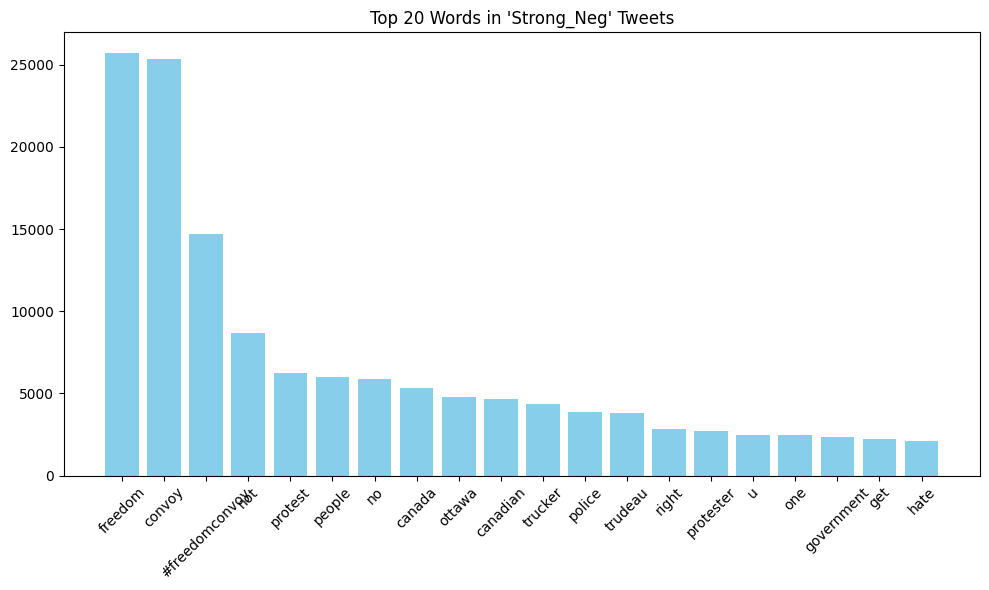

Top 20 words for class 'Mild_Neg':
freedom: 21503
convoy: 21429
#freedomconvoy: 10519
protest: 6351
not: 4793
ottawa: 4616
canada: 4339
canadian: 4044
trucker: 3947
police: 3515
people: 3300
no: 3149
trudeau: 2802
protester: 2476
via: 2401
mandate: 2074
emergency: 1973
u: 1779
right: 1708
government: 1705



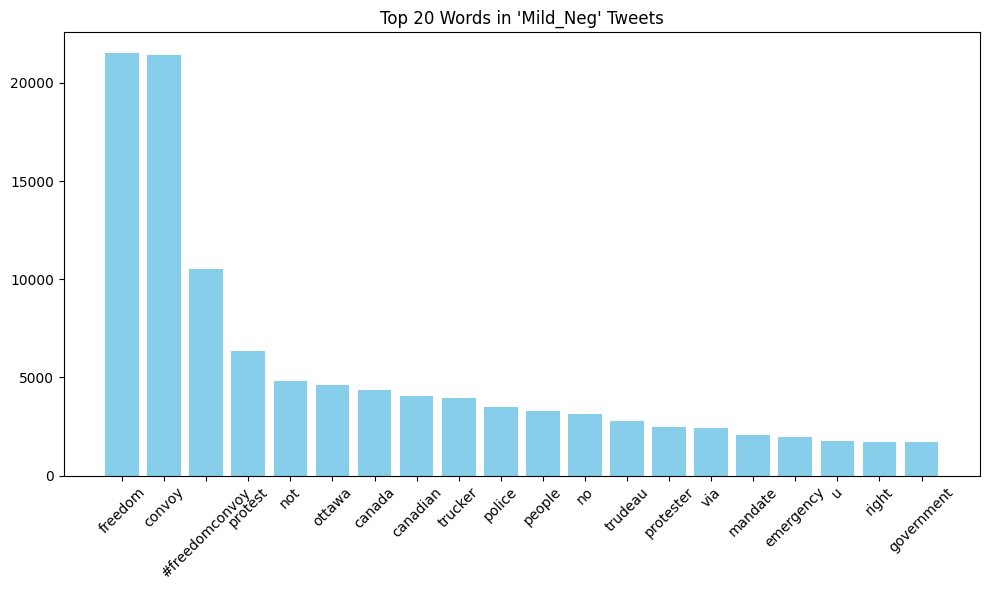

In [ ]:
for sentiment in df['Sentiment'].unique():
    plot_word_freq_for_class(df, sentiment, f"Top 20 Words in '{sentiment}' Tweets")


###Checking and Dropiing columns with nan values

In [ ]:
df.isna().sum()

,0
cleaned_Tweet,17
Sentiment,0


In [ ]:
df = df.dropna()
df.isna().sum()

,0
cleaned_Tweet,0
Sentiment,0


###Making things ready for BiLSTM

In [ ]:
#counting the number of unique words in the cleaned_tweet column
df.columns
len(df.cleaned_Tweet.unique())

386785

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split  # For train-test splitting
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc




In [ ]:
df['cleaned_Tweet'] = df['cleaned_Tweet'].astype(str).replace('nan', '').replace(np.nan, '')
 # Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_Tweet'])
 # Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_Tweet'])
 # Padding sequences
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
 # Convert sentiment labels to numerical values
sentiment_labels = {'Mild_Pos': 0, 'Strong_Pos': 1, 'Neutral': 2, 'Strong_Neg': 3, 'Mild_Neg': 4}
df['Sentiment_Encoded'] = df['Sentiment'].map(sentiment_labels)
 # Convert labels to categorical
labels = to_categorical(df['Sentiment_Encoded'])
 # Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

# Define the model
model = Sequential([
    Embedding(input_dim=20000, output_dim=256, input_length=max_length),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(32)),
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dense(len(sentiment_labels), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
 # Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Stop when validation loss stops decreasing
    patience=3,           # Wait for 3 epochs before stopping
    restore_best_weights=True  # Restore best weights after stopping
)
 # Start timing
start_time = time.time()
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test),callbacks=[early_stopping])
# End timing
end_time = time.time()
# Print total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 114s 74ms/step - accuracy: 0.6407 - loss: 0.9725 - val_accuracy: 0.7576 - val_loss: 0.6749
Epoch 2/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - accuracy: 0.7653 - loss: 0.6530 - val_accuracy: 0.7803 - val_loss: 0.6213
Epoch 3/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - accuracy: 0.8003 - loss: 0.5656 - val_accuracy: 0.7859 - val_loss: 0.6101
Epoch 4/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 143s 75ms/step - accuracy: 0.8217 - loss: 0.5103 - val_accuracy: 0.7839 - val_loss: 0.6236
Epoch 5/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 108s 76ms/step - accuracy: 0.8422 - loss: 0.4576 - val_accuracy: 0.7894 - val_loss: 0.6337
Total training time: 679.87 seconds


In [ ]:
model.save("/content/drive/MyDrive/dataset/Sentiment_Datamodels/bilstm_sentiment_model.keras")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 132, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 132, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 132, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 132, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,279,889 (62.10 MB)

 Trainable params: 5,426,629 (20.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,853,260 (41.40 MB)

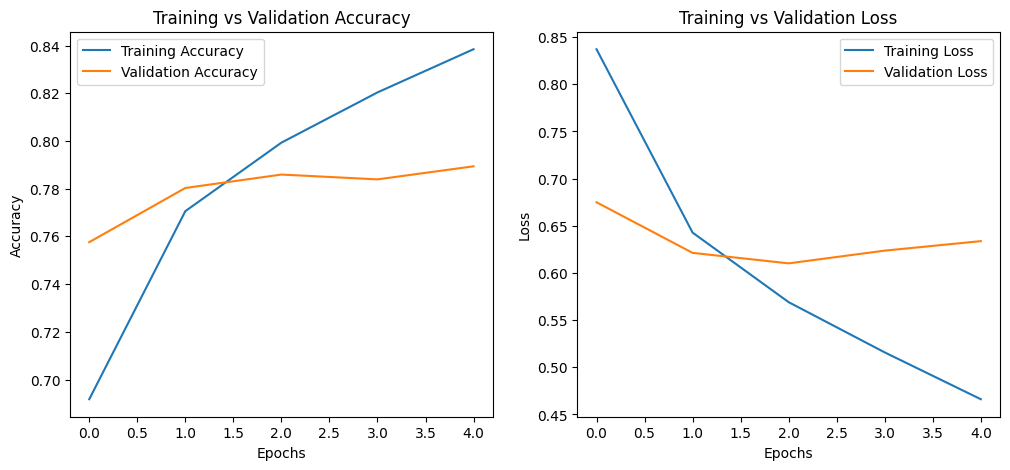

In [ ]:
# Extract metrics from history
history_dict = history.history
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

####Model is not converging and there's some overfitting happening. We can do some tweaks for fine tuning before finally handling imbalance

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on train and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_train_labels = y_train_pred.argmax(axis=1)
y_test_labels = y_test_pred.argmax(axis=1)

# Convert one-hot encoded true labels to class labels
y_train_true = y_train.argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

# Compute Accuracy
train_acc = accuracy_score(y_train_true, y_train_labels)
test_acc = accuracy_score(y_test_true, y_test_labels)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


11283/11283 ━━━━━━━━━━━━━━━━━━━━ 132s 12ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step
Train Accuracy: 0.8298
Test Accuracy: 0.7859


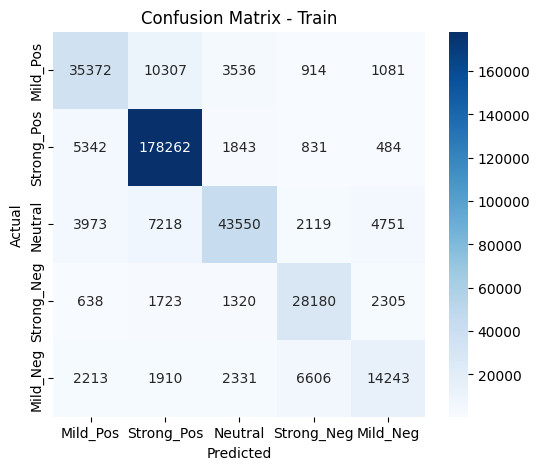

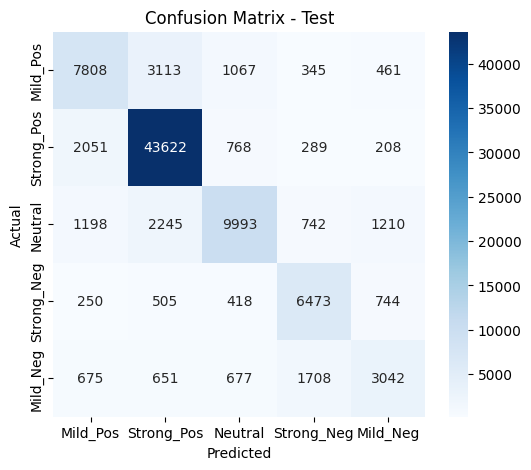

In [ ]:


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_labels.keys(),
                yticklabels=sentiment_labels.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    print("\n\n")

# Plot Confusion Matrices
plot_confusion_matrix(y_train_true, y_train_labels, "Confusion Matrix - Train")
plot_confusion_matrix(y_test_true, y_test_labels, "Confusion Matrix - Test")


In [ ]:
 # Compute AUC
train_auc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.9586
Test AUC: 0.9328


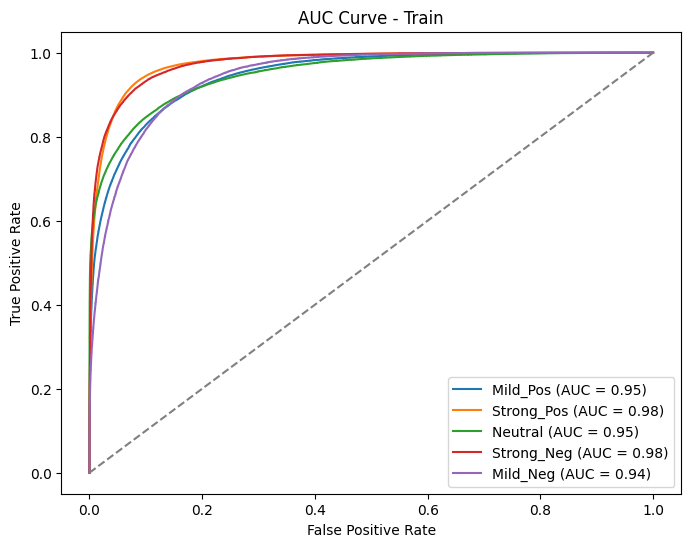

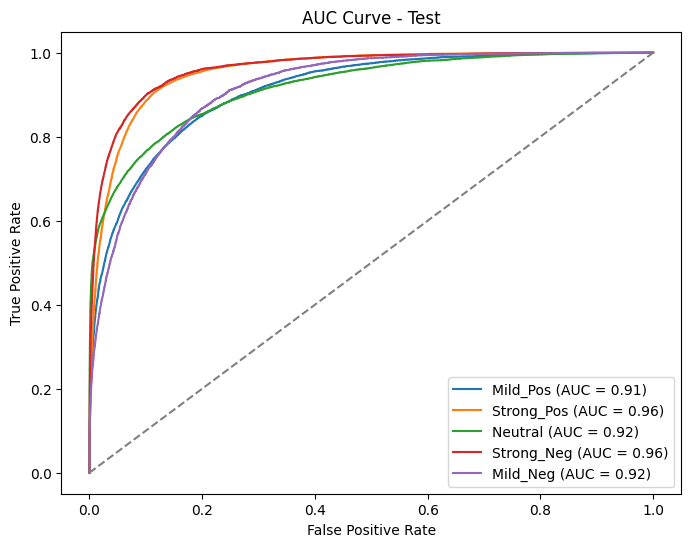

In [ ]:


# Function to plot AUC curve
def plot_auc_curve(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(sentiment_labels.keys()):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()
    print("\n\n")

# Plot AUC for train and test
plot_auc_curve(y_train, y_train_pred, "AUC Curve - Train")
plot_auc_curve(y_test, y_test_pred, "AUC Curve - Test")


### We can increase the amount of dropout

Deep Bidirectional LSTM model updated with:

recurrent_dropout

reduced number of LSTM units

Dropout

BatchNormalization

L2 regularization in Dense layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=20000, output_dim=256, input_length=max_length),

    Bidirectional(LSTM(32, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.7),

    Bidirectional(LSTM(32, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.6),

    Bidirectional(LSTM(16,)),
    Dropout(0.6),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(sentiment_labels), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
 # Define Early Stopping
early_stopping = EarlyStopping(
   monitor='val_loss',   # Stop when validation loss stops decreasing
   patience=3,           # Wait for 3 epochs before stopping
   restore_best_weights=True  # Restore best weights after stopping
)
# Start timing
start_time = time.time()
# Train model
history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test),callbacks=[early_stopping])
# End timing
end_time = time.time()
# Print total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 91s 59ms/step - accuracy: 0.5424 - loss: 1.3172 - val_accuracy: 0.6899 - val_loss: 0.8524
Epoch 2/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 141s 59ms/step - accuracy: 0.6946 - loss: 0.8374 - val_accuracy: 0.7156 - val_loss: 0.7825
Epoch 3/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - accuracy: 0.7405 - loss: 0.7242 - val_accuracy: 0.7582 - val_loss: 0.6886
Epoch 4/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - accuracy: 0.7718 - loss: 0.6538 - val_accuracy: 0.7702 - val_loss: 0.6688
Epoch 5/5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 86s 60ms/step - accuracy: 0.7991 - loss: 0.5865 - val_accuracy: 0.7660 - val_loss: 0.6815
Total training time: 539.32 seconds


In [ ]:
model.save("/content/drive/MyDrive/dataset/Sentiment_Datamodels/bilstm_tune1_sentiment_model.keras")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 132, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 132, 64)        │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 132, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 132, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 132, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 132, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 132, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,692,241 (59.86 MB)

 Trainable params: 5,230,661 (19.95 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 10,461,324 (39.91 MB)

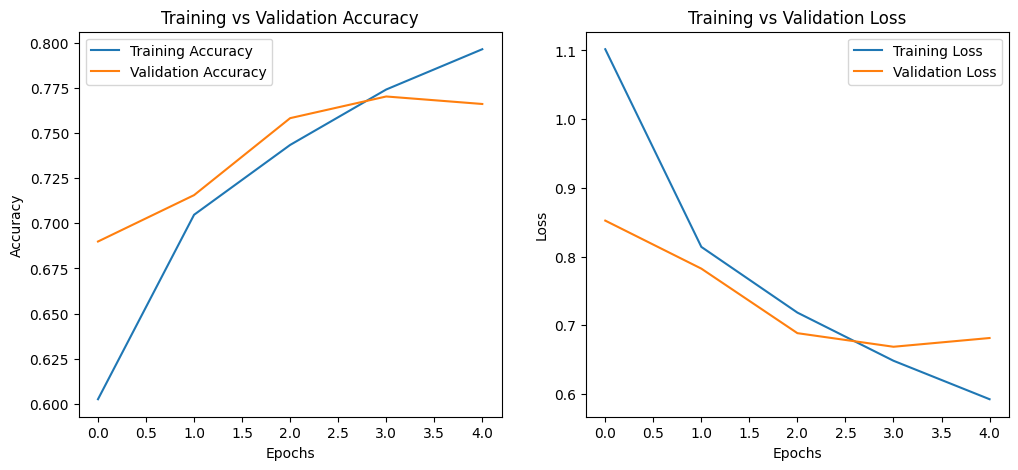

In [ ]:
 # Extract metrics from history
history_dict = history.history
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on train and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_train_labels = y_train_pred.argmax(axis=1)
y_test_labels = y_test_pred.argmax(axis=1)

# Convert one-hot encoded true labels to class labels
y_train_true = y_train.argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

# Compute Accuracy
train_acc = accuracy_score(y_train_true, y_train_labels)
test_acc = accuracy_score(y_test_true, y_test_labels)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


11283/11283 ━━━━━━━━━━━━━━━━━━━━ 138s 12ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step
Train Accuracy: 0.8087
Test Accuracy: 0.7702


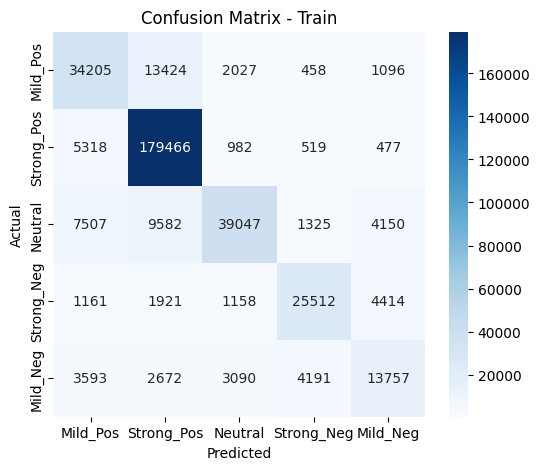

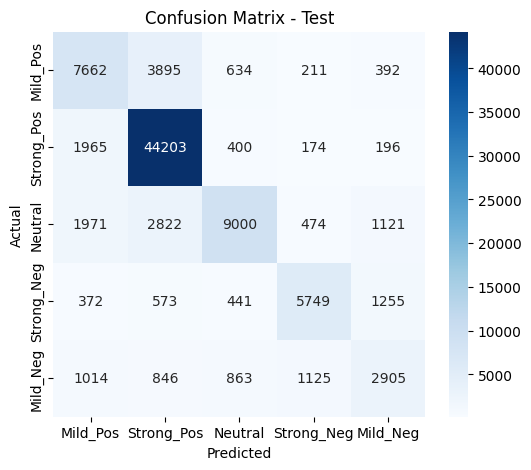

In [ ]:


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_labels.keys(),
                yticklabels=sentiment_labels.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    print("\n\n")

# Plot Confusion Matrices
plot_confusion_matrix(y_train_true, y_train_labels, "Confusion Matrix - Train")
plot_confusion_matrix(y_test_true, y_test_labels, "Confusion Matrix - Test")


In [ ]:
 # Compute AUC
train_auc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train AUC: 0.9462
Test AUC: 0.9212


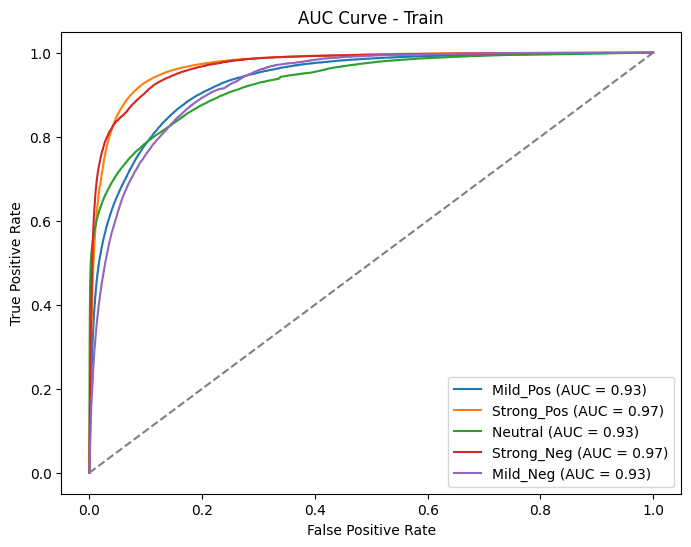

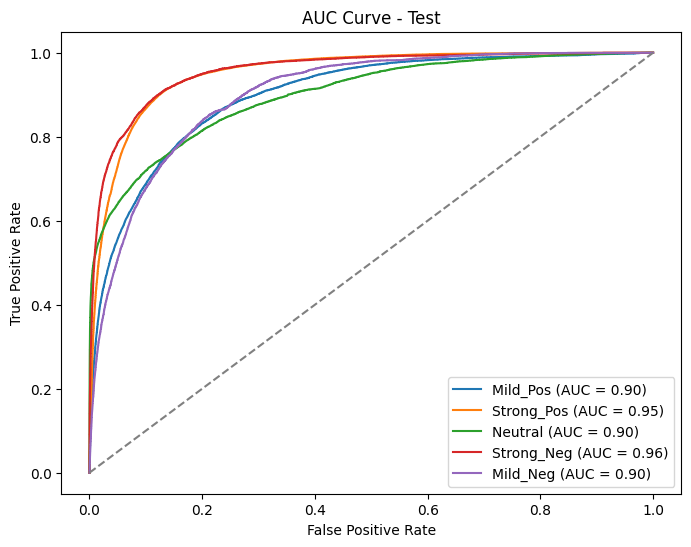

In [ ]:


# Function to plot AUC curve
def plot_auc_curve(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(sentiment_labels.keys()):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()
    print("\n\n")

# Plot AUC for train and test
plot_auc_curve(y_train, y_train_pred, "AUC Curve - Train")
plot_auc_curve(y_test, y_test_pred, "AUC Curve - Test")


##Let's handle the  imbalance

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_3.csv')

### Sampled Data
Took 70k data because while tuning with recurrent dropout it take too much time and crashing the system.

In [ ]:
df_sampled = df.sample(n=70000, random_state=42).reset_index(drop=True)

In [ ]:
df_sampled['cleaned_Tweet'] = df_sampled['cleaned_Tweet'].astype(str).replace('nan', '').replace(np.nan, '')
 # Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_sampled['cleaned_Tweet'])
 # Convert text to sequences
sequences = tokenizer.texts_to_sequences(df_sampled['cleaned_Tweet'])
 # Padding sequences
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
 # Convert sentiment labels to numerical values
sentiment_labels = {'Mild_Pos': 0, 'Strong_Pos': 1, 'Neutral': 2, 'Strong_Neg': 3, 'Mild_Neg': 4}
df_sampled['Sentiment_Encoded'] = df_sampled['Sentiment'].map(sentiment_labels)
 # Convert labels to categorical
labels = to_categorical(df_sampled['Sentiment_Encoded'])
 # Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(56000, 81)

In [ ]:
X_test.shape

(14000, 81)

###Calculating weights to handle inmbalance

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Convert one-hot labels back to integers for computing weights
y_integers = np.argmax(labels, axis=1)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Convert to dictionary form as required by Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


In [ ]:
class_weights_dict

{0: np.float64(1.392757660167131),
 1: np.float64(0.38791909116098644),
 2: np.float64(1.1768661735036987),
 3: np.float64(2.0986358866736623),
 4: np.float64(2.646002646002646)}

In [ ]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=max_length),

    Bidirectional(LSTM(32, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),

    Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2)),
    Dropout(0.5),

    Bidirectional(LSTM(16, recurrent_dropout=0.2)),
    Dropout(0.6),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(sentiment_labels), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
 # Define Early Stopping
early_stopping = EarlyStopping(
   monitor='val_loss',   # Stop when validation loss stops decreasing
   patience=3,           # Wait for 3 epochs before stopping
   restore_best_weights=True  # Restore best weights after stopping
)
# Start timing
start_time = time.time()
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test),callbacks=[early_stopping])
# End timing
end_time = time.time()
# Print total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 213s 915ms/step - accuracy: 0.4922 - loss: 1.5444 - val_accuracy: 0.5750 - val_loss: 1.2017
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 199s 904ms/step - accuracy: 0.5841 - loss: 1.1537 - val_accuracy: 0.6064 - val_loss: 1.0970
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 205s 918ms/step - accuracy: 0.6212 - loss: 1.0099 - val_accuracy: 0.6374 - val_loss: 1.0431
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 201s 912ms/step - accuracy: 0.6478 - loss: 0.9280 - val_accuracy: 0.6502 - val_loss: 1.0069
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 202s 907ms/step - accuracy: 0.6777 - loss: 0.8604 - val_accuracy: 0.6581 - val_loss: 0.9667
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 201s 906ms/step - accuracy: 0.7003 - loss: 0.8129 - val_accuracy: 0.6627 - val_loss: 0.9849
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 203s 911ms/step - accuracy: 0.7136 - loss: 0.7722 - val_accuracy: 0.6678 - val_loss: 1.0220
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 200s 915ms/step - accuracy: 0.7349 -

In [ ]:
model.save("/content/drive/MyDrive/dataset/Sentiment_Datamodels/bilstm_tune3_sentiment_model.keras")

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 81, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 81, 32)         │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 81, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 81, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 81, 16)         │         2,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 81, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 16)             │         1,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,750,737 (29.57 MB)

 Trainable params: 2,583,557 (9.86 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 5,167,116 (19.71 MB)

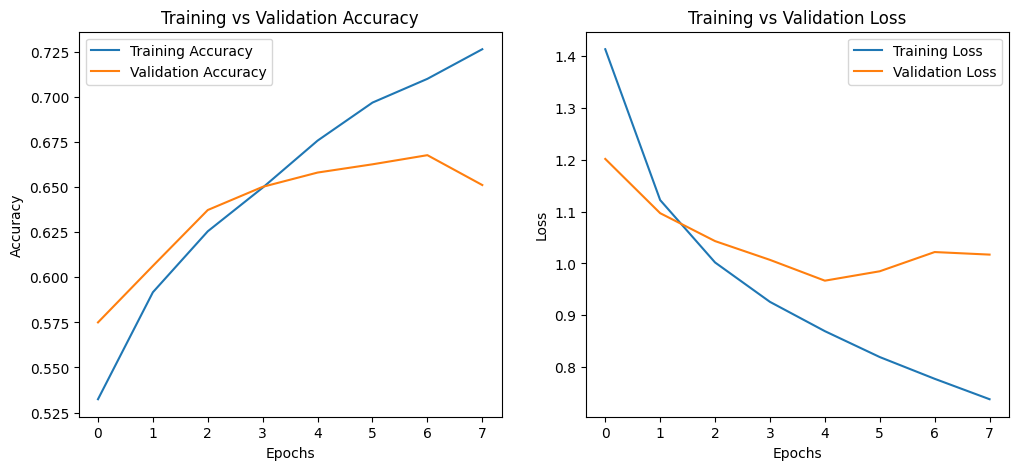

In [ ]:
 # Extract metrics from history
history_dict = history.history
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()